# UNeXt 
> https://github.com/jeya-maria-jose/UNeXt-pytorch

In [1]:
%config Completer.use_jedi = False

## 引入依赖包

In [2]:
!pip install scipy scikit-image torch torchvision pathlib wandb segmentation-models-pytorch timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 43.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 56.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.7 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=e5e92b35a8daba3390a0ef1d81e8c227aaaba5dd605f7a85c831e19c63c44458
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=f1959fa3d6f68834c7fde24d914bbf0411fa33f73f26484d23b9ed1a017b4b7e
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9

In [3]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.nn.functional import relu, pad
from torch.utils.data import Dataset, DataLoader, random_split

from PIL import Image
from typing import Tuple
from pathlib import Path

import torch
from torch import nn, Tensor
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
import wandb
import logging

## 设置wandb账号
用作统计与数据分析

In [4]:
os.environ['WANDB_API_KEY']='d561f1229ba7c4e207ca34042f29a43552a7447e'
!wandb login

wandb: Currently logged in as: torwayland (cupes-wangtao). Use `wandb login --relogin` to force relogin


In [5]:
import torch
from torch import nn
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt
# from utils import *

import timm
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
import types
import math
from abc import ABCMeta, abstractmethod
# from mmcv.cnn import ConvModule
import pdb



def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, bias=False)


def shift(dim):
            x_shift = [ torch.roll(x_c, shift, dim) for x_c, shift in zip(xs, range(-self.pad, self.pad+1))]
            x_cat = torch.cat(x_shift, 1)
            x_cat = torch.narrow(x_cat, 2, self.pad, H)
            x_cat = torch.narrow(x_cat, 3, self.pad, W)
            return x_cat

class shiftmlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0., shift_size=5):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.dim = in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.dwconv = DWConv(hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

        self.shift_size = shift_size
        self.pad = shift_size // 2

        
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()
    
#     def shift(x, dim):
#         x = F.pad(x, "constant", 0)
#         x = torch.chunk(x, shift_size, 1)
#         x = [ torch.roll(x_c, shift, dim) for x_s, shift in zip(x, range(-pad, pad+1))]
#         x = torch.cat(x, 1)
#         return x[:, :, pad:-pad, pad:-pad]

    def forward(self, x, H, W):
        # pdb.set_trace()
        B, N, C = x.shape

        xn = x.transpose(1, 2).view(B, C, H, W).contiguous()
        xn = F.pad(xn, (self.pad, self.pad, self.pad, self.pad) , "constant", 0)
        xs = torch.chunk(xn, self.shift_size, 1)
        x_shift = [torch.roll(x_c, shift, 2) for x_c, shift in zip(xs, range(-self.pad, self.pad+1))]
        x_cat = torch.cat(x_shift, 1)
        x_cat = torch.narrow(x_cat, 2, self.pad, H)
        x_s = torch.narrow(x_cat, 3, self.pad, W)


        x_s = x_s.reshape(B,C,H*W).contiguous()
        x_shift_r = x_s.transpose(1,2)


        x = self.fc1(x_shift_r)

        x = self.dwconv(x, H, W)
        x = self.act(x) 
        x = self.drop(x)

        xn = x.transpose(1, 2).view(B, C, H, W).contiguous()
        xn = F.pad(xn, (self.pad, self.pad, self.pad, self.pad) , "constant", 0)
        xs = torch.chunk(xn, self.shift_size, 1)
        x_shift = [torch.roll(x_c, shift, 3) for x_c, shift in zip(xs, range(-self.pad, self.pad+1))]
        x_cat = torch.cat(x_shift, 1)
        x_cat = torch.narrow(x_cat, 2, self.pad, H)
        x_s = torch.narrow(x_cat, 3, self.pad, W)
        x_s = x_s.reshape(B,C,H*W).contiguous()
        x_shift_c = x_s.transpose(1,2)

        x = self.fc2(x_shift_c)
        x = self.drop(x)
        return x



class shiftedBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm, sr_ratio=1):
        super().__init__()


        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = shiftmlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x, H, W):

        x = x + self.drop_path(self.mlp(self.norm2(x), H, W))
        return x


class DWConv(nn.Module):
    def __init__(self, dim=768):
        super(DWConv, self).__init__()
        self.dwconv = nn.Conv2d(dim, dim, 3, 1, 1, bias=True, groups=dim)

    def forward(self, x, H, W):
        B, N, C = x.shape
        x = x.transpose(1, 2).view(B, C, H, W)
        x = self.dwconv(x)
        x = x.flatten(2).transpose(1, 2)

        return x

class OverlapPatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """

    def __init__(self, img_size=224, patch_size=7, stride=4, in_chans=3, embed_dim=768):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)

        self.img_size = img_size
        self.patch_size = patch_size
        self.H, self.W = img_size[0] // patch_size[0], img_size[1] // patch_size[1]
        self.num_patches = self.H * self.W
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=stride,
                              padding=(patch_size[0] // 2, patch_size[1] // 2))
        self.norm = nn.LayerNorm(embed_dim)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x):
        x = self.proj(x)
        _, _, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)
        x = self.norm(x)

        return x, H, W


class UNext(nn.Module):

    ## Conv 3 + MLP 2 + shifted MLP
    
    def __init__(self,  num_classes, input_channels=3, deep_supervision=False,img_size=224, patch_size=16, in_chans=3,  embed_dims=[ 128, 160, 256],
                 num_heads=[1, 2, 4, 8], mlp_ratios=[4, 4, 4, 4], qkv_bias=False, qk_scale=None, drop_rate=0.,
                 attn_drop_rate=0., drop_path_rate=0., norm_layer=nn.LayerNorm,
                 depths=[1, 1, 1], sr_ratios=[8, 4, 2, 1], **kwargs):
        super().__init__()
        self.num_classes = num_classes
        self.input_channels = input_channels
        self.encoder1 = nn.Conv2d(3, 16, 3, stride=1, padding=1)  
        self.encoder2 = nn.Conv2d(16, 32, 3, stride=1, padding=1)  
        self.encoder3 = nn.Conv2d(32, 128, 3, stride=1, padding=1)

        self.ebn1 = nn.BatchNorm2d(16)
        self.ebn2 = nn.BatchNorm2d(32)
        self.ebn3 = nn.BatchNorm2d(128)
        
        self.norm3 = norm_layer(embed_dims[1])
        self.norm4 = norm_layer(embed_dims[2])

        self.dnorm3 = norm_layer(160)
        self.dnorm4 = norm_layer(128)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]

        self.block1 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[1], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[0], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.block2 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[2], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[1], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.dblock1 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[1], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[0], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.dblock2 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[0], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[1], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.patch_embed3 = OverlapPatchEmbed(img_size=img_size // 4, patch_size=3, stride=2, in_chans=embed_dims[0],
                                              embed_dim=embed_dims[1])
        self.patch_embed4 = OverlapPatchEmbed(img_size=img_size // 8, patch_size=3, stride=2, in_chans=embed_dims[1],
                                              embed_dim=embed_dims[2])

        self.decoder1 = nn.Conv2d(256, 160, 3, stride=1,padding=1)  
        self.decoder2 =   nn.Conv2d(160, 128, 3, stride=1, padding=1)  
        self.decoder3 =   nn.Conv2d(128, 32, 3, stride=1, padding=1) 
        self.decoder4 =   nn.Conv2d(32, 16, 3, stride=1, padding=1)
        self.decoder5 =   nn.Conv2d(16, 16, 3, stride=1, padding=1)

        self.dbn1 = nn.BatchNorm2d(160)
        self.dbn2 = nn.BatchNorm2d(128)
        self.dbn3 = nn.BatchNorm2d(32)
        self.dbn4 = nn.BatchNorm2d(16)
        
        self.final = nn.Conv2d(16, num_classes, kernel_size=1)

        self.soft = nn.Softmax(dim =1)

    def forward(self, x):
        
        B = x.shape[0]
        ### Encoder
        ### Conv Stage

        ### Stage 1
        out = F.relu(F.max_pool2d(self.ebn1(self.encoder1(x)),2,2))
        t1 = out
        ### Stage 2
        out = F.relu(F.max_pool2d(self.ebn2(self.encoder2(out)),2,2))
        t2 = out
        ### Stage 3
        out = F.relu(F.max_pool2d(self.ebn3(self.encoder3(out)),2,2))
        t3 = out

        ### Tokenized MLP Stage
        ### Stage 4

        out,H,W = self.patch_embed3(out)
        for i, blk in enumerate(self.block1):
            out = blk(out, H, W)
        out = self.norm3(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        t4 = out

        ### Bottleneck

        out ,H,W= self.patch_embed4(out)
        for i, blk in enumerate(self.block2):
            out = blk(out, H, W)
        out = self.norm4(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()

        ### Stage 4

        out = F.relu(F.interpolate(self.dbn1(self.decoder1(out)),scale_factor=(2,2),mode ='bilinear'))
        
        out = torch.add(out,t4)
        _,_,H,W = out.shape
        out = out.flatten(2).transpose(1,2)
        for i, blk in enumerate(self.dblock1):
            out = blk(out, H, W)

        ### Stage 3
        
        out = self.dnorm3(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        out = F.relu(F.interpolate(self.dbn2(self.decoder2(out)),scale_factor=(2,2),mode ='bilinear'))
        out = torch.add(out,t3)
        _,_,H,W = out.shape
        out = out.flatten(2).transpose(1,2)
        
        for i, blk in enumerate(self.dblock2):
            out = blk(out, H, W)

        out = self.dnorm4(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()

        out = F.relu(F.interpolate(self.dbn3(self.decoder3(out)),scale_factor=(2,2),mode ='bilinear'))
        out = torch.add(out,t2)
        out = F.relu(F.interpolate(self.dbn4(self.decoder4(out)),scale_factor=(2,2),mode ='bilinear'))
        out = torch.add(out,t1)
        out = F.relu(F.interpolate(self.decoder5(out),scale_factor=(2,2),mode ='bilinear'))

        return self.final(out)


class UNext_S(nn.Module):

    ## Conv 3 + MLP 2 + shifted MLP w less parameters
    
    def __init__(self,  num_classes, input_channels=3, deep_supervision=False,img_size=224, patch_size=16, in_chans=3,  embed_dims=[32, 64, 128, 512],
                 num_heads=[1, 2, 4, 8], mlp_ratios=[4, 4, 4, 4], qkv_bias=False, qk_scale=None, drop_rate=0.,
                 attn_drop_rate=0., drop_path_rate=0., norm_layer=nn.LayerNorm,
                 depths=[1, 1, 1], sr_ratios=[8, 4, 2, 1], **kwargs):
        super().__init__()
        self.input_channels = input_channels
        self.num_classes = num_classes
        self.encoder1 = nn.Conv2d(3, 8, 3, stride=1, padding=1)  
        self.encoder2 = nn.Conv2d(8, 16, 3, stride=1, padding=1)  
        self.encoder3 = nn.Conv2d(16, 32, 3, stride=1, padding=1)

        self.ebn1 = nn.BatchNorm2d(8)
        self.ebn2 = nn.BatchNorm2d(16)
        self.ebn3 = nn.BatchNorm2d(32)
        
        self.norm3 = norm_layer(embed_dims[1])
        self.norm4 = norm_layer(embed_dims[2])

        self.dnorm3 = norm_layer(64)
        self.dnorm4 = norm_layer(32)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]

        self.block1 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[1], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[0], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.block2 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[2], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[1], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.dblock1 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[1], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[0], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.dblock2 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[0], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[1], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.patch_embed3 = OverlapPatchEmbed(img_size=img_size // 4, patch_size=3, stride=2, in_chans=embed_dims[0],
                                              embed_dim=embed_dims[1])
        self.patch_embed4 = OverlapPatchEmbed(img_size=img_size // 8, patch_size=3, stride=2, in_chans=embed_dims[1],
                                              embed_dim=embed_dims[2])

        self.decoder1 = nn.Conv2d(128, 64, 3, stride=1,padding=1)  
        self.decoder2 =   nn.Conv2d(64, 32, 3, stride=1, padding=1)  
        self.decoder3 =   nn.Conv2d(32, 16, 3, stride=1, padding=1) 
        self.decoder4 =   nn.Conv2d(16, 8, 3, stride=1, padding=1)
        self.decoder5 =   nn.Conv2d(8, 8, 3, stride=1, padding=1)

        self.dbn1 = nn.BatchNorm2d(64)
        self.dbn2 = nn.BatchNorm2d(32)
        self.dbn3 = nn.BatchNorm2d(16)
        self.dbn4 = nn.BatchNorm2d(8)
        
        self.final = nn.Conv2d(8, num_classes, kernel_size=1)

        self.soft = nn.Softmax(dim =1)

    def forward(self, x):
        
        B = x.shape[0]
        ### Encoder
        ### Conv Stage

        ### Stage 1
        out = F.relu(F.max_pool2d(self.ebn1(self.encoder1(x)),2,2))
        t1 = out
        ### Stage 2
        out = F.relu(F.max_pool2d(self.ebn2(self.encoder2(out)),2,2))
        t2 = out
        ### Stage 3
        out = F.relu(F.max_pool2d(self.ebn3(self.encoder3(out)),2,2))
        t3 = out

        ### Tokenized MLP Stage
        ### Stage 4

        out,H,W = self.patch_embed3(out)
        for i, blk in enumerate(self.block1):
            out = blk(out, H, W)
        out = self.norm3(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        t4 = out

        ### Bottleneck

        out ,H,W= self.patch_embed4(out)
        for i, blk in enumerate(self.block2):
            out = blk(out, H, W)
        out = self.norm4(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()

        ### Stage 4

        out = F.relu(F.interpolate(self.dbn1(self.decoder1(out)),scale_factor=(2,2),mode ='bilinear'))
        
        out = torch.add(out,t4)
        _,_,H,W = out.shape
        out = out.flatten(2).transpose(1,2)
        for i, blk in enumerate(self.dblock1):
            out = blk(out, H, W)

        ### Stage 3
        
        out = self.dnorm3(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        out = F.relu(F.interpolate(self.dbn2(self.decoder2(out)),scale_factor=(2,2),mode ='bilinear'))
        out = torch.add(out,t3)
        _,_,H,W = out.shape
        out = out.flatten(2).transpose(1,2)
        
        for i, blk in enumerate(self.dblock2):
            out = blk(out, H, W)

        out = self.dnorm4(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()

        out = F.relu(F.interpolate(self.dbn3(self.decoder3(out)),scale_factor=(2,2),mode ='bilinear'))
        out = torch.add(out,t2)
        out = F.relu(F.interpolate(self.dbn4(self.decoder4(out)),scale_factor=(2,2),mode ='bilinear'))
        out = torch.add(out,t1)
        out = F.relu(F.interpolate(self.decoder5(out),scale_factor=(2,2),mode ='bilinear'))

        return self.final(out)


#EOF


## DataSet

In [6]:
# TODO: image和mask名称不一样时跳过
class APODataSet(Dataset):
    # 格式不对的异常数据
    invalid_img = [10, 184, 185]
    def __init__(self, img_dir, mask_dir: str, size, channels = 3) -> None:
        # 获取所有图片路径
        self.img_paths = list(Path(img_dir).glob("*"))
        self.mask_paths = list(Path(mask_dir).glob("*"))
        for idx in self.invalid_img:
            del self.img_paths[idx]
            del self.mask_paths[idx]
        
        
        transformers = [
            transforms.Resize(size),
            transforms.ToTensor()
        ]
        if channels == 1:
            transformers.insert(0, transforms.Grayscale(num_output_channels=1))

        # 设置 transforms
        self.transform = transforms.Compose(transformers)
#         self.transform = transforms.Compose([transforms.PILToTensor()])

    # 使用函数加载原始图像
    def load_orig_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.img_paths[index]
        return Image.open(image_path) 
    
    # 使用函数加载tmask图像
    def load_mask_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.mask_paths[index]
        return Image.open(image_path) 

    #  重写 __len__() 方法 (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.img_paths)

    # 重写 __getitem__() 方法 (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        "Returns one sample of data, image and mask (X, y)."
        orig_img = self.load_orig_image(index)
        mask_img = self.load_mask_image(index)
        
        orig_img = self.transform(orig_img)
        mask_img = self.transform(mask_img)
#         mask_img = mask_img[0]
#         if orig_img.size()[0] != 3:
#             print("{}: orig_img size: {}".format(index,orig_img.size()))
#             return None
        # return data, mask (X, y)
        return orig_img, mask_img


In [7]:
dataset =  APODataSet(img_dir = "/kaggle/input/dltrack/apo_images",
                      mask_dir = "/kaggle/input/dltrack/apo_masks",
                     size = [512, 512])

total = len(dataset)
train_size = int(0.8*total)
validate_size = total - train_size
train_data, validate_data = random_split(dataset, [train_size, validate_size])
print("dataset info\ntotal: {}, train_size: {}, validate_size: {}".format(total, len(train_data), len(validate_data)))

trainloader = DataLoader(dataset=train_data,
                                     batch_size=2,
                                     num_workers=0,
                                     shuffle=True)

valloader = DataLoader(dataset=validate_data,
                                    batch_size=1, 
                                    num_workers=0, 
                                    shuffle=False)

dataset info
total: 571, train_size: 456, validate_size: 115


### 检查异常图片
要把找到的异常数据去除

In [8]:
for index in range(len(dataset)):
    orig_img, mask_img = dataset[index]
    if orig_img.size()[0] != 3:
        print("{}: orig_img size: {}".format(index,orig_img.size()))
print("[done]")

[done]


### 随机显示一张原始图片和其对应的标记图片

torch.Size([3, 512, 512])
showing image of 313: 


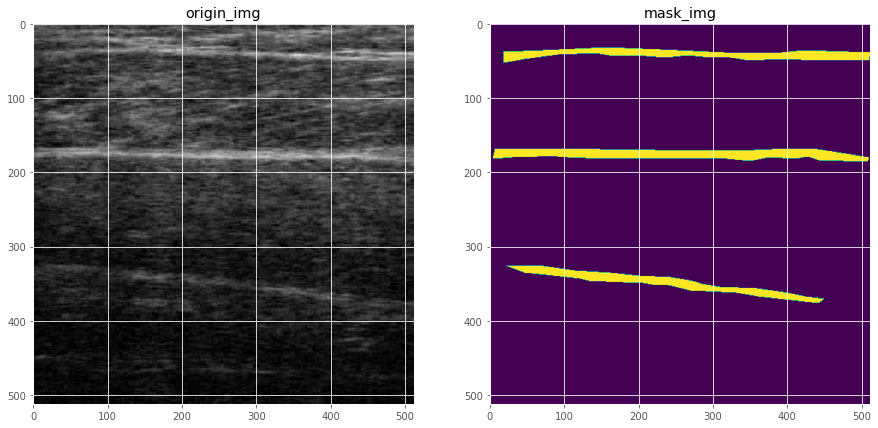

In [9]:
idx = random.randint(0, len(dataset))
orig_img, mask_img = dataset[idx]
print(orig_img.size())

transform = transforms.ToPILImage()
print("showing image of {}: ".format(idx))

orig_img = transform(orig_img)
mask_img = transform(mask_img)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 12))

ax1.imshow(orig_img)
ax1.set_title("origin_img")

ax2.imshow(mask_img)
ax2.set_title("mask_img")

plt.show()

## 模型训练

In [10]:

@torch.inference_mode()
def evaluate(net, dataloader, device, amp):
    net.eval()
    num_val_batches = len(dataloader)
    dice_score = 0
    iou_score = 0

    if isinstance(model, nn.DataParallel):
        num_classes = net.module.num_classes
    else:
        num_classes = net.num_classes
    criterion = nn.CrossEntropyLoss() if num_classes > 1 else nn.BCEWithLogitsLoss()
    dice_loss = smp.losses.DiceLoss(mode='binary', log_loss=True, from_logits = True).cuda()
   
    
    # iterate over the validation set
    with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
        for batch in tqdm(dataloader, total=num_val_batches, desc='Validation round', unit='batch', position=0 ,leave=True):
            image, mask_true = batch

            # move images and labels to correct device and type
            image = image.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
            mask_true = mask_true.to(device=device, dtype=torch.float32)

            # predict the mask
            mask_pred = net(image)
            dice_score += criterion(mask_pred, mask_true.float())
            dice_score += dice_loss(mask_pred, mask_true)
            
            tp, fp, fn, tn = smp.metrics.get_stats(mask_pred, mask_true.long(), mode='binary', threshold=0.5)
            iou_score += smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
            
    dice_loss = (dice_score / max(num_val_batches, 1))
    iou_score = (iou_score / max(num_val_batches, 1))
    print("Validation dice loss: {}, IoU Score {}".format(dice_loss, iou_score))
    return (dice_loss, iou_score)

In [11]:
import time
import torch.optim as optim
import segmentation_models_pytorch as smp

n_train = len(train_data)
n_val = len(validate_data)


def train(model, device, 
          project = 'U-Net',
          epochs: int = 60,
          learning_rate: float = 1e-5, 
          weight_decay: float = 1e-8,
          momentum: float = 0.999,
          batch_size: int = 2,
          amp: bool = False,
          val_percent: float = 0.1,
          gradient_clipping: float = 1.0):
    
    if isinstance(model, nn.DataParallel):
        num_classes = model.module.num_classes
        input_channels = model.module.input_channels
    else:
        num_classes = model.num_classes
        input_channels = model.input_channels
        
    # (Initialize logging)
    experiment = wandb.init(project=project, resume='allow', anonymous='must')
    experiment.config.update(
        dict(epochs=epochs, batch_size=batch_size, learning_rate=learning_rate,
             val_percent=val_percent, amp=amp)
    )

    logging.info(f'''Starting training:
        Epochs:          {epochs}
        Batch size:      {batch_size}
        Learning rate:   {learning_rate}
        Training size:   {n_train}
        Validation size: {n_val}
        Device:          {device.type}
        Mixed Precision: {amp}
    ''')
    

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#     optimizer = optim.SGD(params, lr=config['lr'], momentum=config['momentum'],
#                               nesterov=config['nesterov'], weight_decay=config['weight_decay'])

    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2, eta_min=5e-5)
    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
    
    criterion = nn.CrossEntropyLoss().cuda()
    dice_loss = smp.losses.DiceLoss(mode='binary').cuda()
    
    global_step = 0
    

    # 5. Begin training
    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0
        with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
            for batch in trainloader:
                images, true_masks = batch

                assert images.shape[1] == input_channels, \
                    f'Network has been defined with {input_channels} input channels, ' \
                    f'but loaded images have {images.shape[1]} channels. Please check that ' \
                    'the images are loaded correctly.'

                images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
                
                true_masks = true_masks.to(device=device, dtype=torch.long)

                with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
                    masks_pred = model(images)
                    loss = criterion(masks_pred, true_masks.float())
                    loss += dice_loss(masks_pred, true_masks)
                    tp, fp, fn, tn = smp.metrics.get_stats(masks_pred, true_masks.long(), mode='binary', threshold=0.5)
                    iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
    
                optimizer.zero_grad(set_to_none=True)
                grad_scaler.scale(loss).backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
                grad_scaler.step(optimizer)
                grad_scaler.update()

                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()
                experiment.log({
                    'train iou': iou_score,
                    'train loss': loss.item(),
                    'step': global_step,
                    'epoch': epoch
                })
                pbar.set_postfix(**{'loss (batch)': loss.item()})

                # Evaluation round
                division_step = (n_train // (5 * batch_size))
                if division_step > 0:
                    if global_step % division_step == 0:
                        histograms = {}
                        for tag, value in model.named_parameters():
                            tag = tag.replace('/', '.')
                            if not (torch.isinf(value) | torch.isnan(value)).any():
                                histograms['Weights/' + tag] = wandb.Histogram(value.data.cpu())
                            if not (torch.isinf(value.grad) | torch.isnan(value.grad)).any():
                                histograms['Gradients/' + tag] = wandb.Histogram(value.grad.data.cpu())

                        val_score, iou_score = evaluate(model, valloader, device, amp)
                        model.train()
                        scheduler.step(val_score)

                        logging.info('Validation Dice score: {}'.format(val_score))
                        try:
                            experiment.log({
                                'learning rate': optimizer.param_groups[0]['lr'],
                                'validation Dice': val_score,
                                'validation IoU Score': iou_score,
                                'images': wandb.Image(images[0].cpu()),
                                'masks': {
                                    'true': wandb.Image(true_masks[0].float().cpu()),
                                    'pred': wandb.Image(masks_pred[0].float().cpu()),
                                },
                                'step': global_step,
                                'epoch': epoch,
                                **histograms
                            })
                        except:
                            pass
            


In [12]:
model = UNext_S(input_channels=3, num_classes=1, img_size=512)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)

model = model.to(memory_format=torch.channels_last)
model.to(device)
total_params = sum(p.numel() for p in model.parameters())
print(f"U-Next_S模型参数量为：{total_params}")
print("其详情为：")
for name,parameters in model.named_parameters():
    print(name,':',parameters.size())
    
train(model, device, project='U-Next')


U-Next_S模型参数量为：253561
其详情为：
encoder1.weight : torch.Size([8, 3, 3, 3])
encoder1.bias : torch.Size([8])
encoder2.weight : torch.Size([16, 8, 3, 3])
encoder2.bias : torch.Size([16])
encoder3.weight : torch.Size([32, 16, 3, 3])
encoder3.bias : torch.Size([32])
ebn1.weight : torch.Size([8])
ebn1.bias : torch.Size([8])
ebn2.weight : torch.Size([16])
ebn2.bias : torch.Size([16])
ebn3.weight : torch.Size([32])
ebn3.bias : torch.Size([32])
norm3.weight : torch.Size([64])
norm3.bias : torch.Size([64])
norm4.weight : torch.Size([128])
norm4.bias : torch.Size([128])
dnorm3.weight : torch.Size([64])
dnorm3.bias : torch.Size([64])
dnorm4.weight : torch.Size([32])
dnorm4.bias : torch.Size([32])
block1.0.norm2.weight : torch.Size([64])
block1.0.norm2.bias : torch.Size([64])
block1.0.mlp.fc1.weight : torch.Size([64, 64])
block1.0.mlp.fc1.bias : torch.Size([64])
block1.0.mlp.dwconv.dwconv.weight : torch.Size([64, 1, 3, 3])
block1.0.mlp.dwconv.dwconv.bias : torch.Size([64])
block1.0.mlp.fc2.weight : tor

wandb: Currently logged in as: torwayland (cupes-wangtao). Use `wandb login --relogin` to force relogin


Validation round: 100%|██████████| 115/115 [00:10<00:00, 11.10batch/s]


Validation dice loss: 3.5561728477478027, IoU Score 0.008455603383481503


Validation round: 100%|██████████| 115/115 [00:10<00:00, 10.97batch/s]


Validation dice loss: 3.594773292541504, IoU Score 0.04851177707314491


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.47batch/s]


Validation dice loss: 3.5557281970977783, IoU Score 0.0777859017252922


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.14batch/s]


Validation dice loss: 3.481729507446289, IoU Score 0.11612217128276825


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.17batch/s]


Validation dice loss: 3.44059419631958, IoU Score 0.1143922358751297


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.22batch/s]


Validation dice loss: 3.417478322982788, IoU Score 0.10804543644189835


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.39batch/s]


Validation dice loss: 3.388471841812134, IoU Score 0.10657501965761185


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.00batch/s]


Validation dice loss: 3.3272831439971924, IoU Score 0.11886903643608093


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.94batch/s]


Validation dice loss: 3.3051090240478516, IoU Score 0.120184525847435


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.89batch/s]


Validation dice loss: 3.271707534790039, IoU Score 0.12667210400104523


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.45batch/s]


Validation dice loss: 3.268688440322876, IoU Score 0.11811980605125427


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.10batch/s]


Validation dice loss: 3.251194477081299, IoU Score 0.11641528457403183


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.13batch/s]


Validation dice loss: 3.2297310829162598, IoU Score 0.11962707340717316


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.06batch/s]


Validation dice loss: 3.209106922149658, IoU Score 0.12447749078273773


Validation round: 100%|██████████| 115/115 [00:08<00:00, 14.32batch/s]


Validation dice loss: 3.201106071472168, IoU Score 0.12540067732334137


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.22batch/s]


Validation dice loss: 3.2020976543426514, IoU Score 0.12329717725515366


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.14batch/s]


Validation dice loss: 3.1646392345428467, IoU Score 0.1355462223291397


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.28batch/s]


Validation dice loss: 3.165844202041626, IoU Score 0.13486793637275696


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.52batch/s]


Validation dice loss: 3.158928871154785, IoU Score 0.13631382584571838


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.12batch/s]


Validation dice loss: 3.1286795139312744, IoU Score 0.14776700735092163


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.04batch/s]


Validation dice loss: 3.1114189624786377, IoU Score 0.1568543016910553


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.27batch/s]


Validation dice loss: 3.118863105773926, IoU Score 0.15263859927654266


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.54batch/s]


Validation dice loss: 3.1019880771636963, IoU Score 0.1583823263645172


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.36batch/s]


Validation dice loss: 3.073558807373047, IoU Score 0.17130310833454132


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.01batch/s]


Validation dice loss: 3.049232244491577, IoU Score 0.1827642321586609


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.93batch/s]


Validation dice loss: 3.0239145755767822, IoU Score 0.19508317112922668


Validation round: 100%|██████████| 115/115 [00:08<00:00, 14.21batch/s]


Validation dice loss: 3.0175418853759766, IoU Score 0.19531208276748657


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.30batch/s]


Validation dice loss: 3.007016658782959, IoU Score 0.197666198015213


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.30batch/s]


Validation dice loss: 2.9882700443267822, IoU Score 0.20136018097400665


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.63batch/s]


Validation dice loss: 2.9403395652770996, IoU Score 0.21601063013076782


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.43batch/s]


Validation dice loss: 2.787292003631592, IoU Score 0.25925230979919434


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.29batch/s]


Validation dice loss: 2.60046124458313, IoU Score 0.2715969979763031


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.09batch/s]


Validation dice loss: 2.3479950428009033, IoU Score 0.33537325263023376


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.46batch/s]


Validation dice loss: 2.1309397220611572, IoU Score 0.41167330741882324


Validation round: 100%|██████████| 115/115 [00:08<00:00, 13.87batch/s]


Validation dice loss: 1.9966111183166504, IoU Score 0.4194926917552948


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.94batch/s]


Validation dice loss: 1.806278109550476, IoU Score 0.4713861346244812


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.20batch/s]


Validation dice loss: 1.6998122930526733, IoU Score 0.47296440601348877


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.16batch/s]


Validation dice loss: 1.59055757522583, IoU Score 0.5126535892486572


Validation round: 100%|██████████| 115/115 [00:08<00:00, 14.07batch/s]


Validation dice loss: 1.5002868175506592, IoU Score 0.5198495388031006


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.76batch/s]


Validation dice loss: 1.4655977487564087, IoU Score 0.5176351070404053


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.78batch/s]


Validation dice loss: 1.3993724584579468, IoU Score 0.5435481071472168


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.13batch/s]


Validation dice loss: 1.3372098207473755, IoU Score 0.5560088753700256


Validation round: 100%|██████████| 115/115 [00:08<00:00, 14.05batch/s]


Validation dice loss: 1.2971644401550293, IoU Score 0.5334187150001526


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.05batch/s]


Validation dice loss: 1.281529426574707, IoU Score 0.5667520761489868


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.93batch/s]


Validation dice loss: 1.19267737865448, IoU Score 0.5858711004257202


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.01batch/s]


Validation dice loss: 1.1836791038513184, IoU Score 0.5661093592643738


Validation round: 100%|██████████| 115/115 [00:08<00:00, 13.81batch/s]


Validation dice loss: 1.1901615858078003, IoU Score 0.5766201019287109


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.21batch/s]


Validation dice loss: 1.1407995223999023, IoU Score 0.5863820910453796


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.11batch/s]


Validation dice loss: 1.09231436252594, IoU Score 0.5865845680236816


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.06batch/s]


Validation dice loss: 1.1189693212509155, IoU Score 0.5855666399002075


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.54batch/s]


Validation dice loss: 1.0498701333999634, IoU Score 0.5879353880882263


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.60batch/s]


Validation dice loss: 1.074181079864502, IoU Score 0.5912303328514099


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.04batch/s]


Validation dice loss: 1.002385139465332, IoU Score 0.590700089931488


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.17batch/s]


Validation dice loss: 1.0027283430099487, IoU Score 0.5925756096839905


Validation round: 100%|██████████| 115/115 [00:08<00:00, 14.21batch/s]


Validation dice loss: 0.9616323113441467, IoU Score 0.5980446338653564


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.50batch/s]


Validation dice loss: 0.920084536075592, IoU Score 0.5850095152854919


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.08batch/s]


Validation dice loss: 0.8034778237342834, IoU Score 0.6129072904586792


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.99batch/s]


Validation dice loss: 0.760913610458374, IoU Score 0.613125741481781


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.40batch/s]


Validation dice loss: 0.6946293115615845, IoU Score 0.6193311214447021


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.38batch/s]


Validation dice loss: 0.7017428278923035, IoU Score 0.6029077172279358


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.15batch/s]


Validation dice loss: 0.6262889504432678, IoU Score 0.6304833889007568


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.17batch/s]


Validation dice loss: 0.5985578894615173, IoU Score 0.6388211250305176


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.50batch/s]


Validation dice loss: 0.5903173089027405, IoU Score 0.6170450448989868


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.72batch/s]


Validation dice loss: 0.5769801735877991, IoU Score 0.6252511739730835


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.98batch/s]


Validation dice loss: 0.5523245334625244, IoU Score 0.625781238079071


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.99batch/s]


Validation dice loss: 0.5338069200515747, IoU Score 0.63570636510849


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.41batch/s]


Validation dice loss: 0.5120043754577637, IoU Score 0.642094612121582


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.04batch/s]


Validation dice loss: 0.5153950452804565, IoU Score 0.6323563456535339


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.51batch/s]


Validation dice loss: 0.48808005452156067, IoU Score 0.641785740852356


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.07batch/s]


Validation dice loss: 0.48884063959121704, IoU Score 0.6452870965003967


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.44batch/s]


Validation dice loss: 0.4779262840747833, IoU Score 0.6437813639640808


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.18batch/s]


Validation dice loss: 0.47031930088996887, IoU Score 0.6475685238838196


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.58batch/s]


Validation dice loss: 0.481313019990921, IoU Score 0.6371247172355652


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.13batch/s]


Validation dice loss: 0.5059733986854553, IoU Score 0.6286404132843018


Validation round: 100%|██████████| 115/115 [00:08<00:00, 14.37batch/s]


Validation dice loss: 0.45036381483078003, IoU Score 0.6556026935577393


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.09batch/s]


Validation dice loss: 0.4582774341106415, IoU Score 0.6475480198860168


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.61batch/s]


Validation dice loss: 0.4473521411418915, IoU Score 0.6526810526847839


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.06batch/s]


Validation dice loss: 0.4334409832954407, IoU Score 0.6584437489509583


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.46batch/s]


Validation dice loss: 0.4486672580242157, IoU Score 0.6524477601051331


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.05batch/s]


Validation dice loss: 0.46850061416625977, IoU Score 0.6340100765228271


Validation round: 100%|██████████| 115/115 [00:08<00:00, 14.16batch/s]


Validation dice loss: 0.4394322633743286, IoU Score 0.6507911086082458


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.11batch/s]


Validation dice loss: 0.42423364520072937, IoU Score 0.6607609391212463


Validation round: 100%|██████████| 115/115 [00:08<00:00, 14.06batch/s]


Validation dice loss: 0.44238024950027466, IoU Score 0.650841474533081


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.01batch/s]


Validation dice loss: 0.45796868205070496, IoU Score 0.641049325466156


Validation round: 100%|██████████| 115/115 [00:08<00:00, 14.25batch/s]


Validation dice loss: 0.4572577476501465, IoU Score 0.6389563679695129


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.91batch/s]


Validation dice loss: 0.4167760908603668, IoU Score 0.662399411201477


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.73batch/s]


Validation dice loss: 0.43484076857566833, IoU Score 0.6517905592918396


Validation round: 100%|██████████| 115/115 [00:08<00:00, 14.20batch/s]


Validation dice loss: 0.4203328788280487, IoU Score 0.6614277958869934


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.42batch/s]


Validation dice loss: 0.4188421070575714, IoU Score 0.6586609482765198


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.08batch/s]


Validation dice loss: 0.4166617691516876, IoU Score 0.6617699265480042


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.03batch/s]


Validation dice loss: 0.40234696865081787, IoU Score 0.6676051020622253


Validation round: 100%|██████████| 115/115 [00:08<00:00, 14.26batch/s]


Validation dice loss: 0.4134741425514221, IoU Score 0.66366046667099


Validation round: 100%|██████████| 115/115 [00:08<00:00, 14.28batch/s]


Validation dice loss: 0.4013898968696594, IoU Score 0.6685411930084229


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.15batch/s]


Validation dice loss: 0.4013809263706207, IoU Score 0.6686515212059021


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.11batch/s]


Validation dice loss: 0.40295085310935974, IoU Score 0.6659096479415894


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.43batch/s]


Validation dice loss: 0.3983156979084015, IoU Score 0.6693257093429565


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.42batch/s]


Validation dice loss: 0.40303999185562134, IoU Score 0.6645208597183228


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.04batch/s]


Validation dice loss: 0.4067855775356293, IoU Score 0.6629956960678101


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.12batch/s]


Validation dice loss: 0.39582279324531555, IoU Score 0.6661658883094788


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.57batch/s]


Validation dice loss: 0.4028393626213074, IoU Score 0.6667106747627258


Validation round: 100%|██████████| 115/115 [00:08<00:00, 14.24batch/s]


Validation dice loss: 0.4049109220504761, IoU Score 0.666452169418335


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.07batch/s]


Validation dice loss: 0.39533621072769165, IoU Score 0.6720603704452515


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.23batch/s]


Validation dice loss: 0.40373551845550537, IoU Score 0.6664590835571289


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.60batch/s]


Validation dice loss: 0.39006415009498596, IoU Score 0.6731906533241272


Validation round: 100%|██████████| 115/115 [00:08<00:00, 14.11batch/s]


Validation dice loss: 0.40273696184158325, IoU Score 0.6659858822822571


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.24batch/s]


Validation dice loss: 0.40072670578956604, IoU Score 0.6695151925086975


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.31batch/s]


Validation dice loss: 0.39228877425193787, IoU Score 0.6724027991294861


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.58batch/s]


Validation dice loss: 0.39453837275505066, IoU Score 0.672142744064331


Validation round: 100%|██████████| 115/115 [00:08<00:00, 14.20batch/s]


Validation dice loss: 0.3938616216182709, IoU Score 0.6725780963897705


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.25batch/s]


Validation dice loss: 0.40739408135414124, IoU Score 0.6635646224021912


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.10batch/s]


Validation dice loss: 0.389326810836792, IoU Score 0.6743597388267517


Validation round: 100%|██████████| 115/115 [00:08<00:00, 14.31batch/s]


Validation dice loss: 0.3950250446796417, IoU Score 0.6715267300605774


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.46batch/s]


Validation dice loss: 0.4114137291908264, IoU Score 0.6612204313278198


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.21batch/s]


Validation dice loss: 0.40259498357772827, IoU Score 0.6661087274551392


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.02batch/s]


Validation dice loss: 0.4041731655597687, IoU Score 0.6669985055923462


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.43batch/s]


Validation dice loss: 0.38252317905426025, IoU Score 0.674050509929657


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.41batch/s]


Validation dice loss: 0.40309858322143555, IoU Score 0.6610619425773621


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.21batch/s]


Validation dice loss: 0.4102245271205902, IoU Score 0.657535195350647


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.12batch/s]


Validation dice loss: 0.4028446078300476, IoU Score 0.6649770736694336


Validation round: 100%|██████████| 115/115 [00:08<00:00, 13.71batch/s]


Validation dice loss: 0.41243216395378113, IoU Score 0.6593546271324158


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.13batch/s]


Validation dice loss: 0.3860369622707367, IoU Score 0.6741730570793152


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.02batch/s]


Validation dice loss: 0.3911527693271637, IoU Score 0.6734656095504761


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.16batch/s]


Validation dice loss: 0.393558144569397, IoU Score 0.6718319654464722


Validation round: 100%|██████████| 115/115 [00:08<00:00, 13.26batch/s]


Validation dice loss: 0.3981223404407501, IoU Score 0.6684949994087219


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.23batch/s]


Validation dice loss: 0.3921941816806793, IoU Score 0.672420084476471


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.39batch/s]


Validation dice loss: 0.3990321755409241, IoU Score 0.668495774269104


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.10batch/s]


Validation dice loss: 0.3935748338699341, IoU Score 0.6700588464736938


Validation round: 100%|██████████| 115/115 [00:08<00:00, 13.64batch/s]


Validation dice loss: 0.3805188834667206, IoU Score 0.677019476890564


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.19batch/s]


Validation dice loss: 0.3978365659713745, IoU Score 0.664493978023529


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.26batch/s]


Validation dice loss: 0.40183064341545105, IoU Score 0.6648843884468079


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.27batch/s]


Validation dice loss: 0.4098086357116699, IoU Score 0.6626714468002319


Validation round: 100%|██████████| 115/115 [00:08<00:00, 13.23batch/s]


Validation dice loss: 0.45097509026527405, IoU Score 0.6383820176124573


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.25batch/s]


Validation dice loss: 0.41084930300712585, IoU Score 0.6608709096908569


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.92batch/s]


Validation dice loss: 0.39653316140174866, IoU Score 0.671684741973877


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.95batch/s]


Validation dice loss: 0.389265775680542, IoU Score 0.6713595390319824


Validation round: 100%|██████████| 115/115 [00:08<00:00, 13.54batch/s]


Validation dice loss: 0.38687995076179504, IoU Score 0.6733300685882568


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.84batch/s]


Validation dice loss: 0.38380029797554016, IoU Score 0.6793136596679688


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.20batch/s]


Validation dice loss: 0.38466933369636536, IoU Score 0.6793942451477051


Validation round: 100%|██████████| 115/115 [00:08<00:00, 14.32batch/s]


Validation dice loss: 0.38021671772003174, IoU Score 0.6812988519668579


Validation round: 100%|██████████| 115/115 [00:08<00:00, 14.35batch/s]


Validation dice loss: 0.3783327043056488, IoU Score 0.6806464195251465


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.21batch/s]


Validation dice loss: 0.38857337832450867, IoU Score 0.6763548254966736


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.23batch/s]


Validation dice loss: 0.376991331577301, IoU Score 0.6823391914367676


Validation round: 100%|██████████| 115/115 [00:08<00:00, 14.01batch/s]


Validation dice loss: 0.37985795736312866, IoU Score 0.6806551218032837


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.39batch/s]


Validation dice loss: 0.3896072506904602, IoU Score 0.6723624467849731


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.09batch/s]


Validation dice loss: 0.39290961623191833, IoU Score 0.6734516024589539


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.29batch/s]


Validation dice loss: 0.384574294090271, IoU Score 0.6793532371520996


Validation round: 100%|██████████| 115/115 [00:08<00:00, 13.84batch/s]


Validation dice loss: 0.3787495791912079, IoU Score 0.6779839992523193


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.93batch/s]


Validation dice loss: 0.383870005607605, IoU Score 0.6768174171447754


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.70batch/s]


Validation dice loss: 0.40598586201667786, IoU Score 0.6668617725372314


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.31batch/s]


Validation dice loss: 0.3876674771308899, IoU Score 0.6774248480796814


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.85batch/s]


Validation dice loss: 0.38524317741394043, IoU Score 0.6784558892250061


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.24batch/s]


Validation dice loss: 0.3991732597351074, IoU Score 0.6675813794136047


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.72batch/s]


Validation dice loss: 0.38054484128952026, IoU Score 0.6820008158683777


Validation round: 100%|██████████| 115/115 [00:08<00:00, 14.22batch/s]


Validation dice loss: 0.38335293531417847, IoU Score 0.6806269288063049


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.24batch/s]


Validation dice loss: 0.3787742555141449, IoU Score 0.6831136345863342


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.02batch/s]


Validation dice loss: 0.37669074535369873, IoU Score 0.680379331111908


Validation round: 100%|██████████| 115/115 [00:08<00:00, 14.27batch/s]


Validation dice loss: 0.38676124811172485, IoU Score 0.6778380870819092


Validation round: 100%|██████████| 115/115 [00:08<00:00, 13.55batch/s]


Validation dice loss: 0.3768431842327118, IoU Score 0.6805595755577087


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.42batch/s]


Validation dice loss: 0.3977147042751312, IoU Score 0.6732343435287476


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.33batch/s]


Validation dice loss: 0.3914729356765747, IoU Score 0.6767301559448242


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.42batch/s]


Validation dice loss: 0.39133816957473755, IoU Score 0.6720854640007019


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.66batch/s]


Validation dice loss: 0.3857615888118744, IoU Score 0.6783120036125183


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.14batch/s]


Validation dice loss: 0.39026084542274475, IoU Score 0.6753659844398499


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.35batch/s]


Validation dice loss: 0.39597997069358826, IoU Score 0.6754160523414612


Validation round: 100%|██████████| 115/115 [00:08<00:00, 13.53batch/s]


Validation dice loss: 0.4018785357475281, IoU Score 0.6693094372749329


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.24batch/s]


Validation dice loss: 0.4259156286716461, IoU Score 0.6548478007316589


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.14batch/s]


Validation dice loss: 0.3936958909034729, IoU Score 0.6730839610099792


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.40batch/s]


Validation dice loss: 0.390266090631485, IoU Score 0.6769386529922485


Validation round: 100%|██████████| 115/115 [00:08<00:00, 13.32batch/s]


Validation dice loss: 0.3902508616447449, IoU Score 0.6775380969047546


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.28batch/s]


Validation dice loss: 0.3845941424369812, IoU Score 0.6810331344604492


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.37batch/s]


Validation dice loss: 0.3850819170475006, IoU Score 0.6802721619606018


Validation round: 100%|██████████| 115/115 [00:08<00:00, 13.88batch/s]


Validation dice loss: 0.3877878487110138, IoU Score 0.6791670918464661


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.42batch/s]


Validation dice loss: 0.3866671919822693, IoU Score 0.678268313407898


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.46batch/s]


Validation dice loss: 0.3942470848560333, IoU Score 0.6774019598960876


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.35batch/s]


Validation dice loss: 0.3869497776031494, IoU Score 0.6821839213371277


Validation round: 100%|██████████| 115/115 [00:08<00:00, 14.08batch/s]


Validation dice loss: 0.3970092535018921, IoU Score 0.6754360795021057


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.70batch/s]


Validation dice loss: 0.3864462673664093, IoU Score 0.6822428703308105


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.31batch/s]


Validation dice loss: 0.39997032284736633, IoU Score 0.6735295057296753


Validation round: 100%|██████████| 115/115 [00:08<00:00, 14.35batch/s]


Validation dice loss: 0.3850249648094177, IoU Score 0.6811742782592773


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.31batch/s]


Validation dice loss: 0.3905034363269806, IoU Score 0.6778451800346375


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.54batch/s]


Validation dice loss: 0.3838127851486206, IoU Score 0.6826054453849792


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.30batch/s]


Validation dice loss: 0.3848906457424164, IoU Score 0.6804234981536865


Validation round: 100%|██████████| 115/115 [00:08<00:00, 13.85batch/s]


Validation dice loss: 0.38994359970092773, IoU Score 0.6778362989425659


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.24batch/s]


Validation dice loss: 0.3966044783592224, IoU Score 0.6787350177764893


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.59batch/s]


Validation dice loss: 0.399808406829834, IoU Score 0.6734335422515869


Validation round: 100%|██████████| 115/115 [00:08<00:00, 14.04batch/s]


Validation dice loss: 0.3943979740142822, IoU Score 0.6792049407958984


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.66batch/s]


Validation dice loss: 0.3978966474533081, IoU Score 0.6776002049446106


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.05batch/s]


Validation dice loss: 0.39726755023002625, IoU Score 0.6786440014839172


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.10batch/s]


Validation dice loss: 0.3918946385383606, IoU Score 0.6816745400428772


Validation round: 100%|██████████| 115/115 [00:08<00:00, 12.99batch/s]


Validation dice loss: 0.38934919238090515, IoU Score 0.6813520193099976


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.09batch/s]


Validation dice loss: 0.39098823070526123, IoU Score 0.6795353293418884


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.85batch/s]


Validation dice loss: 0.39912867546081543, IoU Score 0.6766451001167297


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.11batch/s]


Validation dice loss: 0.40630343556404114, IoU Score 0.6701151728630066


Validation round: 100%|██████████| 115/115 [00:08<00:00, 12.96batch/s]


Validation dice loss: 0.38688841462135315, IoU Score 0.6830947399139404


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.14batch/s]


Validation dice loss: 0.4304305613040924, IoU Score 0.654633641242981


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.22batch/s]


Validation dice loss: 0.4037565588951111, IoU Score 0.6745131611824036


Validation round: 100%|██████████| 115/115 [00:08<00:00, 13.45batch/s]


Validation dice loss: 0.4135739505290985, IoU Score 0.6672158241271973


Validation round: 100%|██████████| 115/115 [00:08<00:00, 14.36batch/s]


Validation dice loss: 0.41155505180358887, IoU Score 0.667795717716217


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.17batch/s]


Validation dice loss: 0.38414207100868225, IoU Score 0.6838421821594238


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.97batch/s]


Validation dice loss: 0.3974570631980896, IoU Score 0.6779385209083557


Validation round: 100%|██████████| 115/115 [00:08<00:00, 13.52batch/s]


Validation dice loss: 0.3829207718372345, IoU Score 0.6846715807914734


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.73batch/s]


Validation dice loss: 0.4032192826271057, IoU Score 0.6750290393829346


Validation round: 100%|██████████| 115/115 [00:08<00:00, 14.34batch/s]


Validation dice loss: 0.40482622385025024, IoU Score 0.6752722263336182


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.44batch/s]


Validation dice loss: 0.39223337173461914, IoU Score 0.6797371506690979


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.67batch/s]


Validation dice loss: 0.3856675326824188, IoU Score 0.6832258701324463


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.10batch/s]


Validation dice loss: 0.4059125781059265, IoU Score 0.6731390953063965


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.48batch/s]


Validation dice loss: 0.4107604920864105, IoU Score 0.6699057817459106


Validation round: 100%|██████████| 115/115 [00:08<00:00, 13.29batch/s]


Validation dice loss: 0.41698285937309265, IoU Score 0.6636130213737488


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.24batch/s]


Validation dice loss: 0.4066285192966461, IoU Score 0.6716890931129456


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.04batch/s]


Validation dice loss: 0.3868410587310791, IoU Score 0.6828141808509827


Validation round: 100%|██████████| 115/115 [00:08<00:00, 13.82batch/s]


Validation dice loss: 0.403465211391449, IoU Score 0.6790329217910767


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.14batch/s]


Validation dice loss: 0.39702653884887695, IoU Score 0.6789887547492981


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.04batch/s]


Validation dice loss: 0.3861156404018402, IoU Score 0.6857599020004272


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.35batch/s]


Validation dice loss: 0.4215265214443207, IoU Score 0.6656113862991333


Validation round: 100%|██████████| 115/115 [00:08<00:00, 13.00batch/s]


Validation dice loss: 0.39332541823387146, IoU Score 0.6816930174827576


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.13batch/s]


Validation dice loss: 0.40425220131874084, IoU Score 0.6730232834815979


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.07batch/s]


Validation dice loss: 0.38907018303871155, IoU Score 0.6826345920562744


Validation round: 100%|██████████| 115/115 [00:08<00:00, 13.93batch/s]


Validation dice loss: 0.40416738390922546, IoU Score 0.6791505813598633


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.23batch/s]


Validation dice loss: 0.395702064037323, IoU Score 0.6850021481513977


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.54batch/s]


Validation dice loss: 0.3995746076107025, IoU Score 0.6781703233718872


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.29batch/s]


Validation dice loss: 0.4039325416088104, IoU Score 0.6762068271636963


Validation round: 100%|██████████| 115/115 [00:08<00:00, 13.44batch/s]


Validation dice loss: 0.4060833156108856, IoU Score 0.674382746219635


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.92batch/s]


Validation dice loss: 0.39765751361846924, IoU Score 0.6818222999572754


Validation round: 100%|██████████| 115/115 [00:08<00:00, 14.36batch/s]


Validation dice loss: 0.3905341327190399, IoU Score 0.6834656000137329


Validation round: 100%|██████████| 115/115 [00:08<00:00, 13.43batch/s]


Validation dice loss: 0.4068443775177002, IoU Score 0.6778417229652405


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.33batch/s]


Validation dice loss: 0.4031899869441986, IoU Score 0.6781876087188721


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.09batch/s]


Validation dice loss: 0.40568119287490845, IoU Score 0.6791152954101562


Epoch 45/60: 100%|██████████| 456/456 [02:11<00:00,  3.46img/s, loss (batch)=0.535]


Validation dice loss: 0.3867206275463104, IoU Score 0.6867803931236267


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.51batch/s]


Validation dice loss: 0.41293856501579285, IoU Score 0.6767756342887878


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.94batch/s]


Validation dice loss: 0.40005558729171753, IoU Score 0.6807950139045715


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.17batch/s]


Validation dice loss: 0.410347580909729, IoU Score 0.6741936206817627


Validation round: 100%|██████████| 115/115 [00:09<00:00, 12.46batch/s]


Validation dice loss: 0.3935285806655884, IoU Score 0.6838341355323792


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.41batch/s]


Validation dice loss: 0.3977672755718231, IoU Score 0.6821067333221436


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.35batch/s]


Validation dice loss: 0.41202133893966675, IoU Score 0.6722805500030518


Validation round: 100%|██████████| 115/115 [00:08<00:00, 14.23batch/s]


Validation dice loss: 0.400804340839386, IoU Score 0.6774582862854004


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.27batch/s]


Validation dice loss: 0.4068221151828766, IoU Score 0.6784642934799194


Validation round: 100%|██████████| 115/115 [00:08<00:00, 14.23batch/s]


Validation dice loss: 0.39702489972114563, IoU Score 0.6828627586364746


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.05batch/s]


Validation dice loss: 0.4065612852573395, IoU Score 0.678980827331543


Validation round: 100%|██████████| 115/115 [00:08<00:00, 13.26batch/s]


Validation dice loss: 0.3966563940048218, IoU Score 0.6804309487342834


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.25batch/s]


Validation dice loss: 0.39803096652030945, IoU Score 0.6826555132865906


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.74batch/s]


Validation dice loss: 0.40736350417137146, IoU Score 0.6769900918006897


Validation round: 100%|██████████| 115/115 [00:08<00:00, 13.06batch/s]


Validation dice loss: 0.41778212785720825, IoU Score 0.6719096302986145


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.35batch/s]


Validation dice loss: 0.4101698100566864, IoU Score 0.6767157316207886


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.19batch/s]


Validation dice loss: 0.38888901472091675, IoU Score 0.6860809922218323


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.55batch/s]


Validation dice loss: 0.3958667814731598, IoU Score 0.6836018562316895


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.48batch/s]


Validation dice loss: 0.40546178817749023, IoU Score 0.6793259978294373


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.16batch/s]


Validation dice loss: 0.40360769629478455, IoU Score 0.6800020337104797


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.40batch/s]


Validation dice loss: 0.41235852241516113, IoU Score 0.6759904026985168


Validation round: 100%|██████████| 115/115 [00:09<00:00, 12.52batch/s]


Validation dice loss: 0.39654120802879333, IoU Score 0.6835719347000122


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.26batch/s]


Validation dice loss: 0.3956247866153717, IoU Score 0.682770311832428


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.36batch/s]


Validation dice loss: 0.4335693120956421, IoU Score 0.665664792060852


Validation round: 100%|██████████| 115/115 [00:08<00:00, 13.33batch/s]


Validation dice loss: 0.40482309460639954, IoU Score 0.6788818836212158


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.11batch/s]


Validation dice loss: 0.40706464648246765, IoU Score 0.6799696683883667


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.62batch/s]


Validation dice loss: 0.42115291953086853, IoU Score 0.6732196807861328


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.37batch/s]


Validation dice loss: 0.4089750647544861, IoU Score 0.6785055994987488


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.56batch/s]


Validation dice loss: 0.46195897459983826, IoU Score 0.6482846736907959


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.41batch/s]


Validation dice loss: 0.42301687598228455, IoU Score 0.6704012751579285


Validation round: 100%|██████████| 115/115 [00:08<00:00, 14.33batch/s]


Validation dice loss: 0.43361955881118774, IoU Score 0.6647489070892334


Validation round: 100%|██████████| 115/115 [00:08<00:00, 13.03batch/s]


Validation dice loss: 0.42094916105270386, IoU Score 0.669671893119812


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.07batch/s]


Validation dice loss: 0.4011496901512146, IoU Score 0.6812848448753357


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.03batch/s]


Validation dice loss: 0.4161987602710724, IoU Score 0.6779908537864685


Validation round: 100%|██████████| 115/115 [00:08<00:00, 13.25batch/s]


Validation dice loss: 0.4010876715183258, IoU Score 0.6821355223655701


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.87batch/s]


Validation dice loss: 0.4290207624435425, IoU Score 0.670432984828949


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.07batch/s]


Validation dice loss: 0.4013288617134094, IoU Score 0.6823840737342834


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.93batch/s]


Validation dice loss: 0.42247775197029114, IoU Score 0.6739007830619812


Validation round: 100%|██████████| 115/115 [00:08<00:00, 13.47batch/s]


Validation dice loss: 0.4280166029930115, IoU Score 0.6696434617042542


Validation round: 100%|██████████| 115/115 [00:08<00:00, 14.21batch/s]


Validation dice loss: 0.43064776062965393, IoU Score 0.6694161891937256


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.06batch/s]


Validation dice loss: 0.4037596881389618, IoU Score 0.6807867288589478


Validation round: 100%|██████████| 115/115 [00:08<00:00, 12.87batch/s]


Validation dice loss: 0.39845743775367737, IoU Score 0.6852735877037048


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.98batch/s]


Validation dice loss: 0.4100266098976135, IoU Score 0.6815468668937683


Validation round: 100%|██████████| 115/115 [00:08<00:00, 14.30batch/s]


Validation dice loss: 0.4139772355556488, IoU Score 0.6786973476409912


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.02batch/s]


Validation dice loss: 0.40502113103866577, IoU Score 0.6804668307304382


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.84batch/s]


Validation dice loss: 0.40613678097724915, IoU Score 0.6824635863304138


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.34batch/s]


Validation dice loss: 0.41769376397132874, IoU Score 0.6749184131622314


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.04batch/s]


Validation dice loss: 0.417796790599823, IoU Score 0.677676260471344


Validation round: 100%|██████████| 115/115 [00:08<00:00, 12.97batch/s]


Validation dice loss: 0.40714868903160095, IoU Score 0.6796441078186035


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.31batch/s]


Validation dice loss: 0.40870219469070435, IoU Score 0.6809768080711365


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.31batch/s]


Validation dice loss: 0.4139076769351959, IoU Score 0.676218569278717


Validation round: 100%|██████████| 115/115 [00:08<00:00, 12.92batch/s]


Validation dice loss: 0.41375797986984253, IoU Score 0.678131639957428


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.62batch/s]


Validation dice loss: 0.4013449251651764, IoU Score 0.6835252046585083


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.37batch/s]


Validation dice loss: 0.40978559851646423, IoU Score 0.681501030921936


Validation round: 100%|██████████| 115/115 [00:08<00:00, 13.77batch/s]


Validation dice loss: 0.41518378257751465, IoU Score 0.6791719794273376


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.11batch/s]


Validation dice loss: 0.4347909688949585, IoU Score 0.6655864715576172


Validation round: 100%|██████████| 115/115 [00:08<00:00, 14.35batch/s]


Validation dice loss: 0.4262727200984955, IoU Score 0.6739476323127747


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.22batch/s]


Validation dice loss: 0.40384194254875183, IoU Score 0.6842577457427979


Validation round: 100%|██████████| 115/115 [00:08<00:00, 14.30batch/s]


Validation dice loss: 0.42774054408073425, IoU Score 0.6714911460876465


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.12batch/s]


Validation dice loss: 0.4175306260585785, IoU Score 0.6777955889701843


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.13batch/s]


Validation dice loss: 0.4410085678100586, IoU Score 0.6638922691345215


Validation round: 100%|██████████| 115/115 [00:08<00:00, 12.80batch/s]


Validation dice loss: 0.4535917341709137, IoU Score 0.6593615412712097


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.30batch/s]


Validation dice loss: 0.4426786005496979, IoU Score 0.6629700660705566


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.39batch/s]


Validation dice loss: 0.4062625765800476, IoU Score 0.6822161078453064


Validation round: 100%|██████████| 115/115 [00:08<00:00, 13.21batch/s]


Validation dice loss: 0.4384019672870636, IoU Score 0.6716185808181763


Validation round: 100%|██████████| 115/115 [00:08<00:00, 14.37batch/s]


Validation dice loss: 0.44585442543029785, IoU Score 0.6636850237846375


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.30batch/s]


Validation dice loss: 0.4106840491294861, IoU Score 0.6790761351585388


Validation round: 100%|██████████| 115/115 [00:08<00:00, 13.61batch/s]


Validation dice loss: 0.4096485376358032, IoU Score 0.6810126900672913


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.20batch/s]


Validation dice loss: 0.4157925248146057, IoU Score 0.6787728071212769


Validation round: 100%|██████████| 115/115 [00:07<00:00, 14.43batch/s]


Validation dice loss: 0.42317995429039, IoU Score 0.6780135631561279


Validation round: 100%|██████████| 115/115 [00:08<00:00, 14.29batch/s]


Validation dice loss: 0.4434715509414673, IoU Score 0.6637157201766968


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.20batch/s]


Validation dice loss: 0.4086948335170746, IoU Score 0.6816674470901489


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.26batch/s]


Validation dice loss: 0.42775654792785645, IoU Score 0.6698571443557739


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.19batch/s]


Validation dice loss: 0.41190028190612793, IoU Score 0.6798830032348633


Validation round: 100%|██████████| 115/115 [00:08<00:00, 14.31batch/s]


Validation dice loss: 0.416790634393692, IoU Score 0.680435836315155


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.29batch/s]


Validation dice loss: 0.42194223403930664, IoU Score 0.6723204851150513


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.40batch/s]


Validation dice loss: 0.42842721939086914, IoU Score 0.6713554263114929


Epoch 60/60: 100%|██████████| 456/456 [02:11<00:00,  3.46img/s, loss (batch)=0.173]
